In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [92]:
data = pd.read_csv("fraudTest.csv")



In [93]:
data.drop([
    'index','cc_num','first','last','street',
    'zip','trans_num'
], axis=1, inplace=True, errors='ignore')



In [94]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])





In [95]:
data['trans_hour'] = data['trans_date_trans_time'].dt.hour
data['trans_day'] = data['trans_date_trans_time'].dt.day
data['trans_month'] = data['trans_date_trans_time'].dt.month



In [96]:
data.drop('trans_date_trans_time', axis=1, inplace=True)



In [97]:
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']


In [98]:
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = 2026 - data['dob'].dt.year
data.drop('dob', axis=1, inplace=True)



In [99]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in data.select_dtypes(include='object').columns:
    data[col] = le.fit_transform(data[col])


In [100]:
print(data.dtypes)





Unnamed: 0       int64
merchant         int64
category         int64
amt            float64
gender           int64
city             int64
state            int64
lat            float64
long           float64
city_pop         int64
job              int64
unix_time        int64
merch_lat      float64
merch_long     float64
is_fraud         int64
trans_hour       int32
trans_day        int32
trans_month      int32
age              int32
dtype: object


In [101]:
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']



In [102]:
from sklearn.utils import resample

fraud = data[data.is_fraud == 1]
legit = data[data.is_fraud == 0]

legit_sample = resample(
    legit,
    replace=False,
    n_samples=len(fraud),
    random_state=42
)

balanced_data = pd.concat([legit_sample, fraud])


In [103]:
X = balanced_data.drop('is_fraud', axis=1)
y = balanced_data['is_fraud']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [104]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


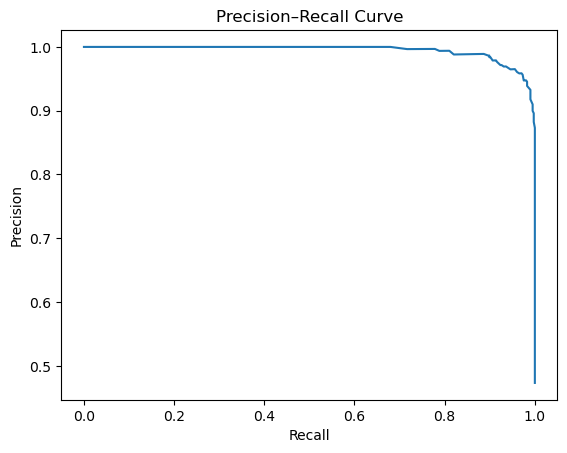

In [112]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
y_prob = rf.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()



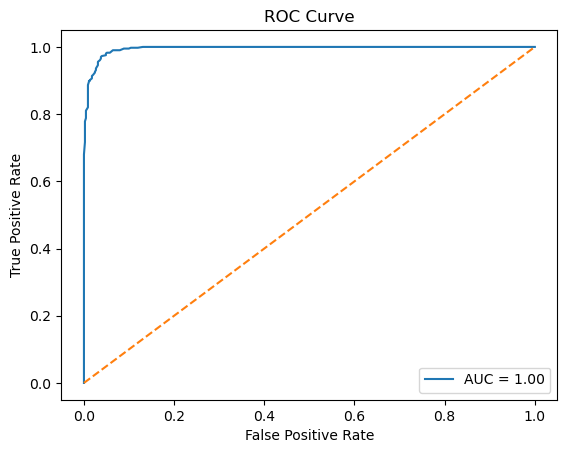

In [106]:
from sklearn.metrics import roc_curve, auc

y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


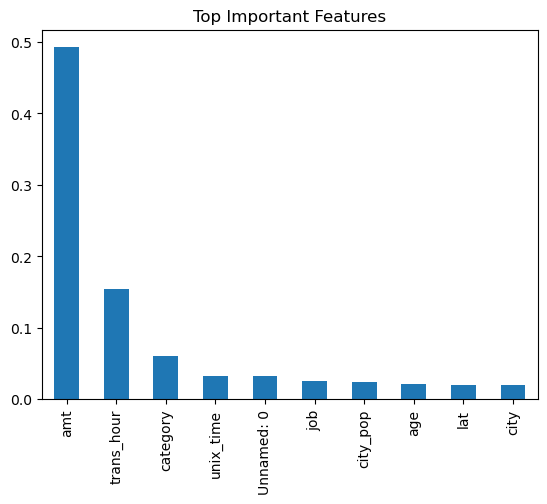

In [107]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10).plot(kind='bar')
plt.title("Top Important Features")
plt.show()


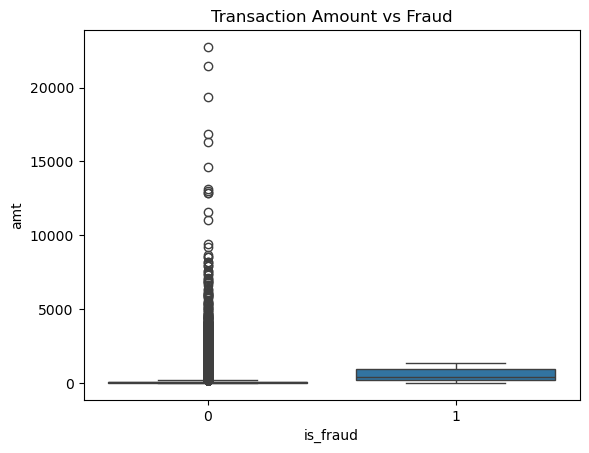

In [108]:
sns.boxplot(x='is_fraud', y='amt', data=data)
plt.title("Transaction Amount vs Fraud")
plt.show()


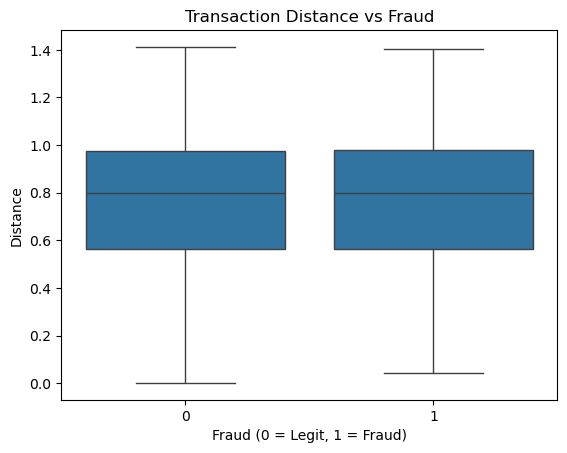

In [110]:
import numpy as np

data['distance'] = np.sqrt(
    (data['lat'] - data['merch_lat'])**2 +
    (data['long'] - data['merch_long'])**2
)

sns.boxplot(x='is_fraud', y='distance', data=data)
plt.title("Transaction Distance vs Fraud")
plt.xlabel("Fraud (0 = Legit, 1 = Fraud)")
plt.ylabel("Distance")
plt.show()


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       452
           1       0.96      0.96      0.96       406

    accuracy                           0.96       858
   macro avg       0.96      0.96      0.96       858
weighted avg       0.96      0.96      0.96       858



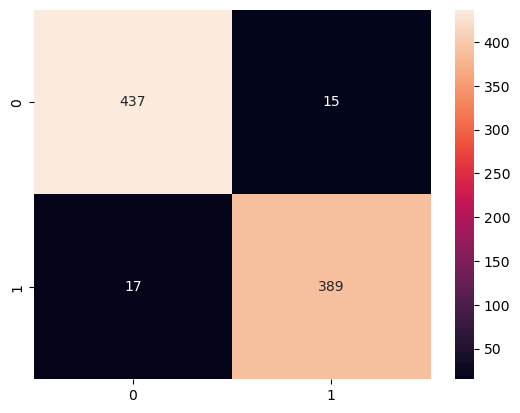

In [109]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()
